In [50]:
## Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import salem

# OGGM
import oggm.cfg as cfg
from oggm import utils, workflow, tasks, graphics

In [51]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')
cfg.PARAMS['use_multiprocessing'] = False
# Local working directory (where OGGM will write its output)
cfg.PATHS['working_dir'] = utils.gettempdir('OGGM_Toy_Thickness_Model')
# We use the directories with the shop data in it: "W5E5_w_data"
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/'
gdirs = workflow.init_glacier_directories(['RGI60-15.06559'], from_prepro_level=3, prepro_base_url=base_url, prepro_border=10)

2023-08-08 10:41:51: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-08-08 10:41:51: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-08-08 10:41:51: oggm.cfg: Multiprocessing: using all available processors (N=8)
2023-08-08 10:41:52: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2023-08-08 10:41:52: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
100% of 167.6 MiB |######################| Elapsed Time: 0:00:18 Time:  0:00:18


In [52]:
# Pick our glacier
gdir = gdirs[0]
gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-15.06559
  Region: 15: South Asia East
  Subregion: 15-01: C Himalaya                      
  Glacier type: Glacier
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 11.736 km2
  Lon, Lat: (79.729660034, 30.701324463)
  Grid (nx, ny): (174, 96)
  Grid (dx, dy): (58.0, -58.0)

In [53]:
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()
# List all variables
ds

<xarray.Dataset>
Dimensions:                  (x: 174, y: 96)
Coordinates:
  * x                        (x) float32 -2.914e+03 -2.856e+03 ... 7.12e+03
  * y                        (y) float32 3.399e+06 3.399e+06 ... 3.393e+06
Data variables: (12/14)
    topo                     (y, x) float32 5.641e+03 5.782e+03 ... 4.595e+03
    topo_smoothed            (y, x) float32 5.776e+03 5.824e+03 ... 4.601e+03
    topo_valid_mask          (y, x) int8 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    glacier_mask             (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    glacier_ext              (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    consensus_ice_thickness  (y, x) float32 nan nan nan nan ... nan nan nan nan
    ...                       ...
    itslive_v                (y, x) float32 0.2415 0.2357 ... 0.3044 0.1664
    millan_ice_thickness     (y, x) float32 nan nan nan nan ... nan nan nan nan
    millan_v                 (y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    millan_vx                (y, x) float32 nan nan nan nan ... nan nan nan nan
    millan_vy                (y, x) float32 nan nan nan nan ... nan nan nan nan
    hugonnet_dhdt            (y, x) float32 0.002672 0.00261 ... -0.01249
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=79.729660034 +k=0.9996 +x_0=0...
    max_h_dem:      6699.0
    min_h_dem:      3825.0
    max_h_glacier:  6334.0
    min_h_glacier:  3938.0

In [54]:
import salem
import matplotlib.pyplot as plt
smap = ds.salem.get_map(countries=False)
smap.set_shapefile(gdir.read_shapefile('outlines'))
smap.set_topography(ds.topo.data);

In [61]:
# get the velocity data
u = ds.itslive_vx.where(ds.glacier_mask)
v = ds.itslive_vy.where(ds.glacier_mask)
ws = ds.itslive_v.where(ds.glacier_mask)

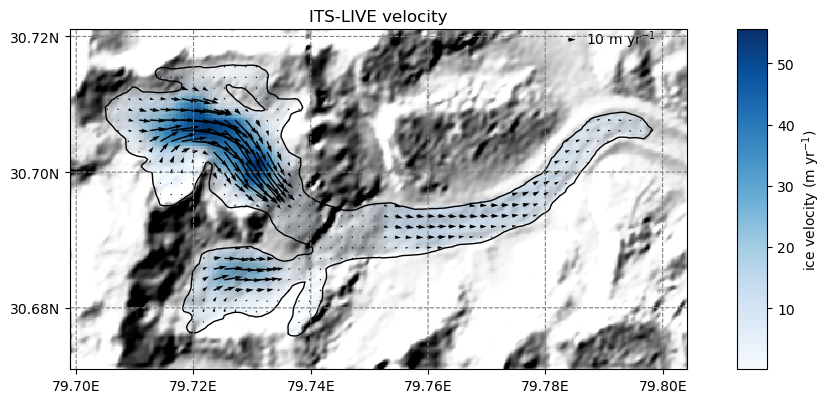

In [62]:
# get the axes ready
f, ax = plt.subplots(figsize=(9, 9))

# Quiver only every N grid point
us = u[1::3, 1::3]
vs = v[1::3, 1::3]

smap.set_data(ws)
smap.set_cmap('Blues')
smap.plot(ax=ax)
smap.append_colorbar(ax=ax, label='ice velocity (m yr$^{-1}$)')

# transform their coordinates to the map reference system and plot the arrows
xx, yy = smap.grid.transform(us.x.values, us.y.values, crs=gdir.grid.proj)
xx, yy = np.meshgrid(xx, yy)
qu = ax.quiver(xx, yy, us.values, vs.values)
qk = ax.quiverkey(qu, 0.82, 0.97, 10, '10 m yr$^{-1}$',
                  labelpos='E', coordinates='axes')
ax.set_title('ITS-LIVE velocity');

In [63]:
# get the velocity data
u = ds.millan_vx.where(ds.glacier_mask)
v = ds.millan_vy.where(ds.glacier_mask)
ws = ds.millan_v.where(ds.glacier_mask)

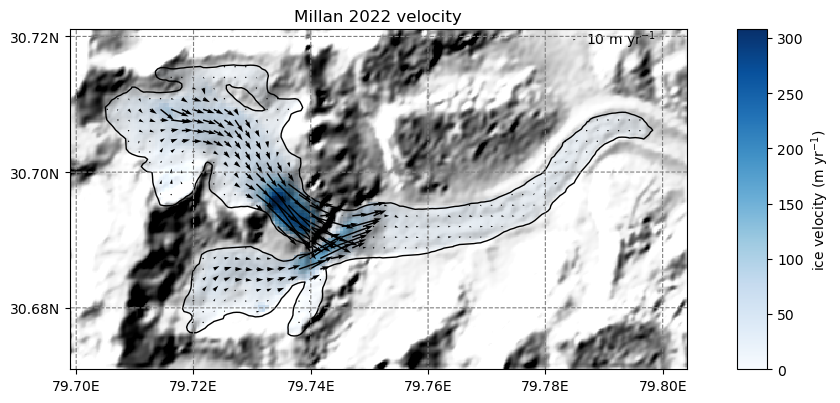

In [64]:
# get the axes ready
f, ax = plt.subplots(figsize=(9, 9))

# Quiver only every N grid point
us = u[1::3, 1::3]
vs = v[1::3, 1::3]

smap.set_data(ws)
smap.set_cmap('Blues')
smap.plot(ax=ax)
smap.append_colorbar(ax=ax, label='ice velocity (m yr$^{-1}$)')

# transform their coordinates to the map reference system and plot the arrows
xx, yy = smap.grid.transform(us.x.values, us.y.values, crs=gdir.grid.proj)
xx, yy = np.meshgrid(xx, yy)
qu = ax.quiver(xx, yy, us.values, vs.values)
qk = ax.quiverkey(qu, 0.82, 0.97, 10, '10 m yr$^{-1}$',
                  labelpos='E', coordinates='axes')
ax.set_title('Millan 2022 velocity');

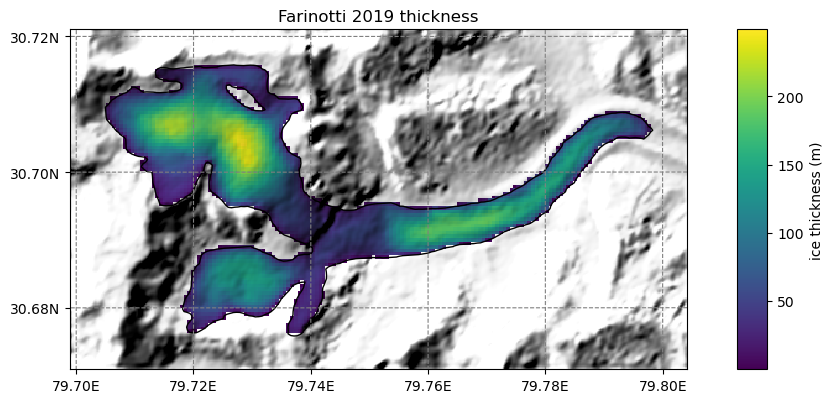

In [65]:
# get the axes ready
f, ax = plt.subplots(figsize=(9, 9))
smap.set_cmap('viridis')
smap.set_data(ds.consensus_ice_thickness)
smap.plot(ax=ax)
smap.append_colorbar(ax=ax, label='ice thickness (m)')
ax.set_title('Farinotti 2019 thickness');

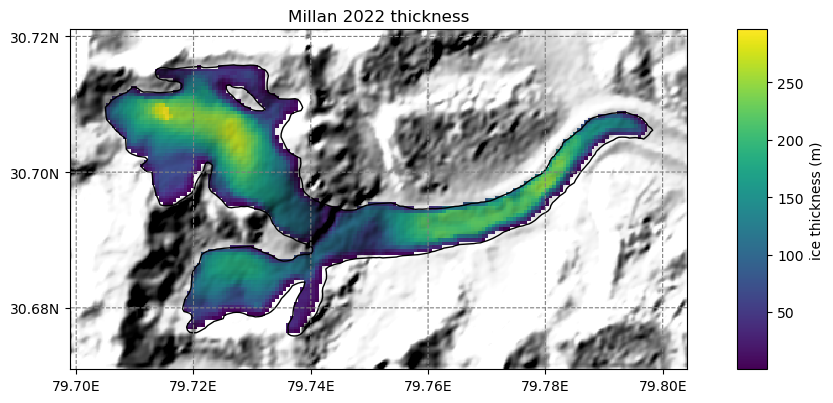

In [66]:
# get the axes ready
f, ax = plt.subplots(figsize=(9, 9))
smap.set_cmap('viridis')
smap.set_data(ds.millan_ice_thickness.where(ds.glacier_mask))
smap.plot(ax=ax)
smap.append_colorbar(ax=ax, label='ice thickness (m)')
ax.set_title('Millan 2022 thickness');

In [67]:
# Tested tasks
task_list = [
    tasks.gridded_attributes,
    tasks.gridded_mb_attributes,
]
for task in task_list:
    workflow.execute_entity_task(task, gdirs)

2023-08-08 10:57:35: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers
2023-08-08 10:57:35: oggm.workflow: Execute entity tasks [gridded_mb_attributes] on 1 glaciers


In [68]:
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()
# List all variables
ds

<xarray.Dataset>
Dimensions:                  (x: 174, y: 96)
Coordinates:
  * x                        (x) float32 -2.914e+03 -2.856e+03 ... 7.12e+03
  * y                        (y) float32 3.399e+06 3.399e+06 ... 3.393e+06
Data variables: (12/23)
    topo                     (y, x) float32 5.641e+03 5.782e+03 ... 4.595e+03
    topo_smoothed            (y, x) float32 5.776e+03 5.824e+03 ... 4.601e+03
    topo_valid_mask          (y, x) int8 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    glacier_mask             (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    glacier_ext              (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    consensus_ice_thickness  (y, x) float32 nan nan nan nan ... nan nan nan nan
    ...                       ...
    aspect                   (y, x) float32 5.278 5.154 5.066 ... 4.072 3.924
    slope_factor             (y, x) float32 1.168 1.1 1.043 ... 1.464 1.548
    dis_from_border          (y, x) float32 1.303e+03 1.273e+03 ... 3.449e+03
    catchment_area           (y, x) float32 nan nan nan nan ... nan nan nan nan
    lin_mb_above_z           (y, x) float32 nan nan nan nan ... nan nan nan nan
    oggm_mb_above_z          (y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=79.729660034 +k=0.9996 +x_0=0...
    max_h_dem:      6699.0
    min_h_dem:      3825.0
    max_h_glacier:  6334.0
    min_h_glacier:  3938.0

In [69]:
ds.oggm_mb_above_z

<xarray.DataArray 'oggm_mb_above_z' (y: 96, x: 174)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x        (x) float32 -2.914e+03 -2.856e+03 -2.798e+03 ... 7.062e+03 7.12e+03
  * y        (y) float32 3.399e+06 3.399e+06 3.399e+06 ... 3.393e+06 3.393e+06
Attributes:
    units:        kg/year
    long_name:    MB above point from OGGM MB model, without catchments
    description:  Mass balance cumulated above the altitude of thepoint, henc...

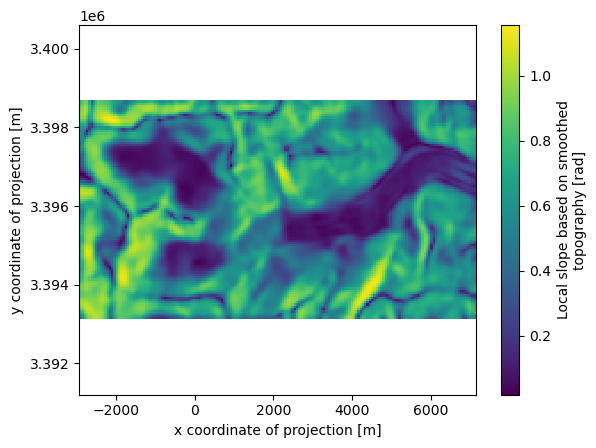

In [70]:
ds.slope.plot();
plt.axis('equal');

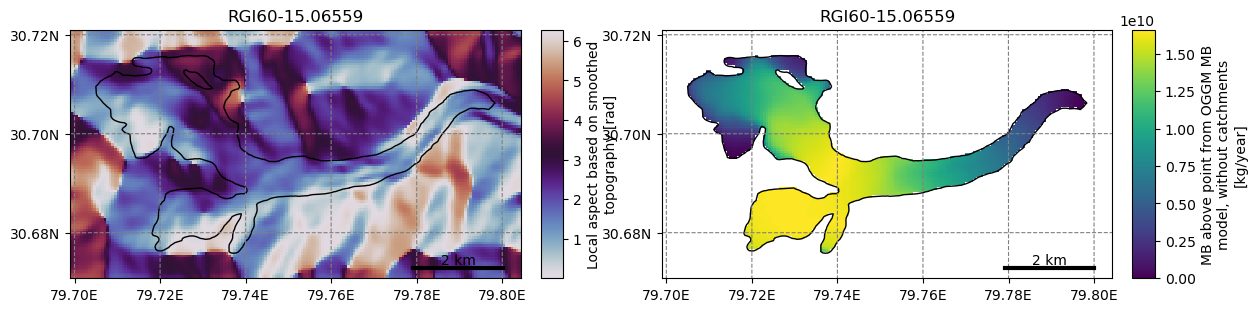

In [71]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
graphics.plot_raster(gdir, var_name='aspect', cmap='twilight', ax=ax1)
graphics.plot_raster(gdir, var_name='oggm_mb_above_z', ax=ax2)